# Regridding the Lat/Lon Airtemp dataset to H3



In [1]:
import os

# The variable is named ESMFMKFILE, and it must point to the esmf.mk file 

esmfmk = "/Users/akmoch/micromamba/envs/xa_dggs/lib/esmf.mk"
os.environ["ESMFMKFILE"] = esmfmk

In [2]:
import xagg as xa
import xarray as xr
import numpy as np
import geopandas as gpd
import xdggs

import matplotlib as mpl
import matplotlib.pyplot as plt

/Users/akmoch/micromamba/envs/xa_dggs/lib/python3.10/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [5]:
ds = xr.tutorial.load_dataset("air_temperature").load()
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

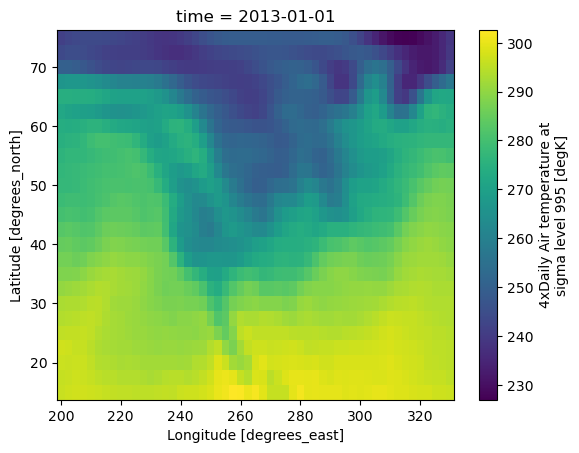

In [6]:
ds.air.isel(time=0).plot()

In [9]:
from cartopy import crs as ccrs


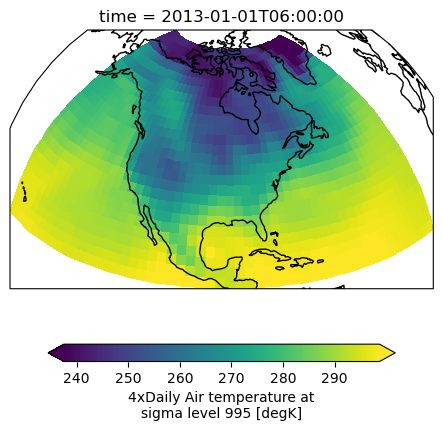

In [10]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Orthographic(-90, 30)))

ds.air.isel(time=1).plot(
    ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,
)
axis.coastlines()  # cartopy function

In [11]:
from h3 import h3

In [23]:
resolution = 2

lon, lat = xr.broadcast(ds.lon, ds.lat)
## %time index = h3.unstable.vect.geo_to_h3(lat.data.ravel(), lon.data.ravel(), resolution)
%time index = [h3.geo_to_h3(la, lo, resolution) for (la, lo) in zip(lat.data.ravel(), lon.data.ravel())]
# index.shape = lon.shape

len(np.unique(index)) / lon.size

CPU times: user 2.54 ms, sys: 154 µs, total: 2.69 ms
Wall time: 2.68 ms


0.6037735849056604

In [24]:
# index.shape
len(index)

1325

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame({"geometry": None, "id": index}, index=index)

In [27]:
df

,geometry,id
820d37fffffffff,None,820d37fffffffff
820d07fffffffff,None,820d07fffffffff
820d1ffffffffff,None,820d1ffffffffff
820c37fffffffff,None,820c37fffffffff
820c07fffffffff,None,820c07fffffffff
...,...,...
8234d7fffffffff,None,8234d7fffffffff
82572ffffffffff,None,82572ffffffffff
825777fffffffff,None,825777fffffffff
825757fffffffff,None,825757fffffffff


In [36]:
import shapely
from shapely.geometry import shape, mapping, Polygon

In [37]:
df['geometry'] = df.apply(lambda r: Polygon(h3.h3_to_geo_boundary(r['id'], geo_json=True)), axis=1)

In [38]:
df

,geometry,id
820d37fffffffff,POLYGON ((-163.45686807900944 76.1455673260825...,820d37fffffffff
820d07fffffffff,"POLYGON ((-156.68473650523 73.75085590328372, ...",820d07fffffffff
820d1ffffffffff,POLYGON ((-160.79790121243346 71.0076187613270...,820d1ffffffffff
820c37fffffffff,POLYGON ((-163.8729684603252 68.21921734529467...,820c37fffffffff
820c07fffffffff,POLYGON ((-159.2859373808439 66.02866715337115...,820c07fffffffff
...,...,...
8234d7fffffffff,POLYGON ((-30.386417332925895 27.6177238571309...,8234d7fffffffff
82572ffffffffff,POLYGON ((-31.655200285380122 24.7947026994589...,82572ffffffffff
825777fffffffff,POLYGON ((-29.59996504669809 22.40230279430893...,825777fffffffff
825757fffffffff,POLYGON ((-30.824900138109847 19.6862191064201...,825757fffffffff


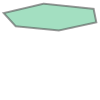

In [39]:
shapely.geometry.Polygon(df.iloc[0,0])

In [40]:
gdf2 = gpd.GeoDataFrame(df, geometry="geometry", crs=4326)
bb = shapely.geometry.box(-160,15,-30,70)

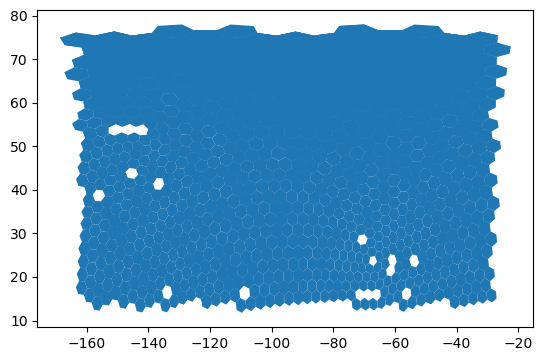

In [42]:
ax = gdf2.plot()
# gpd.GeoDataFrame({'geometry':[bb]}, crs=4326).plot(ax=ax, color="gray")

In [43]:
ll = h3.polyfill(bb.__geo_interface__, geo_json_conformant=True, res=2)

In [44]:
df3 = pd.DataFrame(ll).rename(columns={0:"h3"})

In [45]:
df3['geometry'] = df3.apply(
    lambda r: Polygon(h3.h3_to_geo_boundary(r['h3'], geo_json=True)), axis=1)

In [46]:
gdf3x = gpd.GeoDataFrame(df3, crs=4326)

<Axes: >

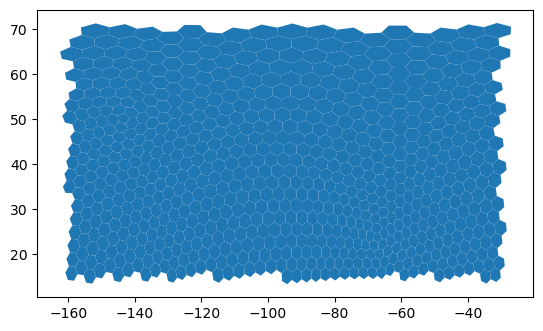

In [47]:
gdf3x.plot()

In [58]:
gdf3x_h3 =  gdf3x.set_index("h3", drop=True)
gdf3x_h3

,geometry
h3,
8244affffffffff,"POLYGON ((-80.69856 26.06269, -79.21173 26.761..."
82506ffffffffff,"POLYGON ((-141.50188 24.18117, -142.71887 22.8..."
821227fffffffff,"POLYGON ((-120.00772 63.45393, -121.99326 62.1..."
821247fffffffff,"POLYGON ((-107.13363 57.29953, -109.36840 56.1..."
821d97fffffffff,"POLYGON ((-154.37896 52.03225, -152.85036 53.0..."
...,...
82379ffffffffff,"POLYGON ((-157.66270 34.85325, -158.85034 33.5..."
822777fffffffff,"POLYGON ((-88.65412 49.81242, -91.06290 49.082..."
8244cffffffffff,"POLYGON ((-84.76158 33.83307, -83.10474 34.505..."


In [48]:
ds = xr.tutorial.load_dataset("air_temperature").load()
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [63]:
# Calculate overlaps
# weightmap = xa.pixel_overlaps(ds.rename_dims({"ni": "x", "nj": "y"}),gdf)
weightmap = xa.pixel_overlaps(ds,gdf3x)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!


In [65]:
weightmap

In [66]:
aggregated = xa.aggregate(ds,weightmap)

aggregating air...
all variables aggregated to polygons!


In [67]:
aggregated.to_dataset()

<xarray.Dataset>
Dimensions:   (poly_idx: 734, time: 2920)
Coordinates:
  * poly_idx  (poly_idx) int64 0 1 2 3 4 5 6 7 ... 727 728 729 730 731 732 733
  * time      (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    h3        (poly_idx) object '8244affffffffff' ... '8237b7fffffffff'
    air       (poly_idx, time) float64 291.9 291.0 291.3 ... 284.4 284.3 284.5

In [68]:
df_out = aggregated.to_dataframe()
df_out

h3         air
poly_idx time                                            
0        2013-01-01 00:00:00  8244affffffffff  291.928844
         2013-01-01 06:00:00  8244affffffffff  290.991863
         2013-01-01 12:00:00  8244affffffffff  291.332539
         2013-01-01 18:00:00  8244affffffffff  295.942891
         2013-01-02 00:00:00  8244affffffffff  294.423418
...                                       ...         ...
733      2014-12-30 18:00:00  8237b7fffffffff  284.574539
         2014-12-31 00:00:00  8237b7fffffffff  284.226385
         2014-12-31 06:00:00  8237b7fffffffff  284.443336
         2014-12-31 12:00:00  8237b7fffffffff  284.262802
         2014-12-31 18:00:00  8237b7fffffffff  284.549624

[2143280 rows x 2 columns]

In [69]:
first_entries = df_out.groupby(level='poly_idx').first()

In [27]:
type(first_entries)

pandas.core.frame.DataFrame

In [70]:
fe = first_entries.set_index("h3", drop=True)
fe

,air
h3,
8244affffffffff,291.928844
82506ffffffffff,292.308513
821227fffffffff,268.661277
821247fffffffff,256.314794
821d97fffffffff,277.408885
...,...
82379ffffffffff,289.964278
822777fffffffff,257.991575
8244cffffffffff,278.451939


In [73]:
air_df = gdf3x.set_index("h3", drop=True).join(fe)

In [74]:
type(air_df)

geopandas.geodataframe.GeoDataFrame

<Axes: >

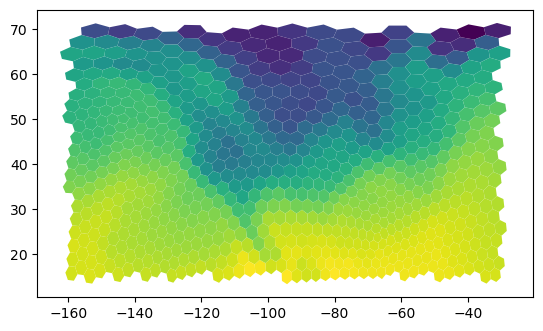

In [75]:
air_df.plot(column="air", cmap="viridis")

In [76]:
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts, tile_sources as gvts


import matplotlib.pyplot as plt
%matplotlib inline

gv.extension('matplotlib')

gv.output(fig='png', size=300)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [77]:

earth_polyview = gv.Polygons(
    air_df, vdims=['air']
).opts( projection=ccrs.Orthographic(-90, 30) )



# test geoviews orthographic view
img = earth_polyview.opts(
    projection=ccrs.Orthographic(-90, 30), global_extent=False, edgecolor='None',
    xaxis=None, yaxis=None, show_grid=True,
    show_frame=True, colorbar=True, fig_size=300, color='air', cmap='viridis' ) * gf.coastline

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (air)
   .Coastline.I :Feature   [Longitude,Latitude]
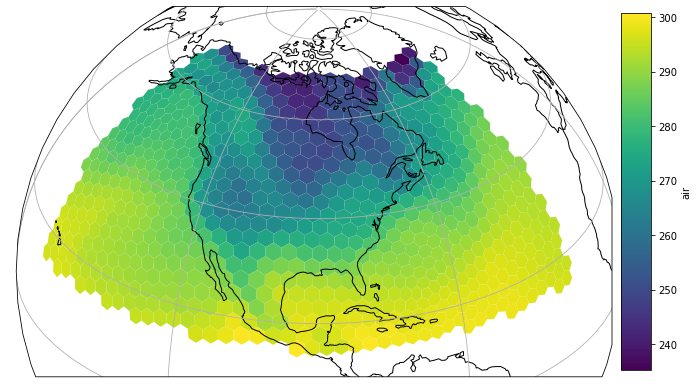

In [78]:
img

In [79]:
type(img)

holoviews.core.overlay.Overlay

In [80]:
gv.save(img, 'xagg_h3_air.png')

In [105]:
ds.lon.max().compute()

<xarray.DataArray 'lon' ()>
array(-30., dtype=float32)